# EEG to ECG Reconstruction


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from gpr_utils import  train_pulse
import os
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torchinfo import summary

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/andrea/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
load_from_file = True

# Parameters and setup
A = 2              # Amplitude of the train pulses
width = 0.05       # Width of each pulse
tau = 5            # Lag (downsampling factor)
duration_sec = 10  # segment length to plot

# Available subjects (info only)
subj_all = [29, 41, 30, 40, 23, 27, 28, 39]

# Pulse type for ECG transformation
impulso = "Gaussian"   # or rectangular

# Caching paths
cache_dir = "cache"
parsed_path = os.path.join(cache_dir, "data_parsed.pkl")
preproc_path = os.path.join(cache_dir, "data_preprocessed.pkl")

In [3]:
# Time warping augmentation parameters
use_augmentation = True
aug_segment_duration = 14  # seconds (larger than target 10s to allow for warping)
warp_factor_range = (0.85, 1.15)  # random warping between 85% and 115% of original length
n_augmented_per_segment = 5  # number of warped versions to create per original segment

def apply_time_warp(signal, axis=-1):
    """
    Apply random time warping to a signal along the specified axis.
    signal: array (can be 1D or 2D)
    Returns: warped signal with random length between warp_factor_range
    """
    original_len = signal.shape[axis]
    warp_factor = np.random.uniform(*warp_factor_range)
    new_len = int(original_len * warp_factor)
    
    old_indices = np.linspace(0, original_len - 1, original_len)
    new_indices = np.linspace(0, original_len - 1, new_len)
    
    if signal.ndim == 1:
        # 1D signal (e.g., ECG_pulse)
        interp_func = interp1d(old_indices, signal, kind='linear', fill_value='extrapolate')
        warped = interp_func(new_indices)
    else:
        # 2D signal (e.g., EEG with channels)
        if axis == -1 or axis == 1:
            # Time is last dimension
            warped = np.zeros((signal.shape[0], new_len))
            for ch in range(signal.shape[0]):
                interp_func = interp1d(old_indices, signal[ch, :], kind='linear', fill_value='extrapolate')
                warped[ch, :] = interp_func(new_indices)
        else:
            # Time is first dimension
            warped = np.zeros((new_len, signal.shape[1]))
            for ch in range(signal.shape[1]):
                interp_func = interp1d(old_indices, signal[:, ch], kind='linear', fill_value='extrapolate')
                warped[:, ch] = interp_func(new_indices)
    
    return warped

def extract_random_window(signal, target_len, axis=-1):
    """
    Extract a random window of target_len from signal along axis.
    """
    current_len = signal.shape[axis]
    if current_len < target_len:
        raise ValueError(f"Signal length {current_len} < target {target_len}")
    
    max_start = current_len - target_len
    start_idx = np.random.randint(0, max_start + 1) if max_start > 0 else 0
    
    if signal.ndim == 1:
        return signal[start_idx:start_idx + target_len]
    else:
        if axis == -1 or axis == 1:
            return signal[:, start_idx:start_idx + target_len]
        else:
            return signal[start_idx:start_idx + target_len, :]

## Build training data
Loads preprocessed EEG, creates ECG pulse trains from R-peaks, normalizes, downsamples, and concatenates across training subjects.

In [4]:
def visualize_ecg_and_peaks(ss, ECG, ECG_pulse, EEG, R_peaks, time, freq, duration_sec=10):
    print(f"ECG -> Sampling frequency: {freq} Hz, Signal duration: {len(ECG)/freq} seconds, Channels: 1, no. of points: {len(ECG)}, no. of R peaks: {len(R_peaks)}")
    print(f"EEG -> Sampling frequency: {freq} Hz, Signal duration: {EEG.shape[1]/freq} seconds, Channels: {EEG.shape[0]}, no. of points: {EEG.shape[1]}")

    # Random start index
    start_idx = np.random.randint(0, len(time) - int(duration_sec * freq))
    end_idx = start_idx + int(duration_sec * freq)

    # Select R peaks in the segment and shift to relative indices
    R_seg = R_peaks[(R_peaks >= start_idx) & (R_peaks < end_idx)]

    plt.figure(figsize=(12, 4))
    plt.plot(time[start_idx:end_idx], ECG[start_idx:end_idx], label='ECG')
    plt.plot(time[start_idx:end_idx], ECG_pulse[start_idx:end_idx], label='Pulses')
    plt.scatter(time[R_seg], ECG[R_seg], s=20, edgecolors='red', facecolors='red', label='R_peaks')

    # Add dashed vertical lines at R peaks
    for rp in R_seg:
        plt.axvline(time[rp], color='k', linestyle='--', alpha=0.8, linewidth=1) # type: ignore

    plt.title(f'ECG and Pulses, Random 10s Segment, Subject {ss}')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.tight_layout()
    plt.show()

Loaded data_parsed from cache/data_parsed.pkl
ECG -> Sampling frequency: 500.0 Hz, Signal duration: 466.57 seconds, Channels: 1, no. of points: 233285, no. of R peaks: 546
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 466.57 seconds, Channels: 90, no. of points: 233285


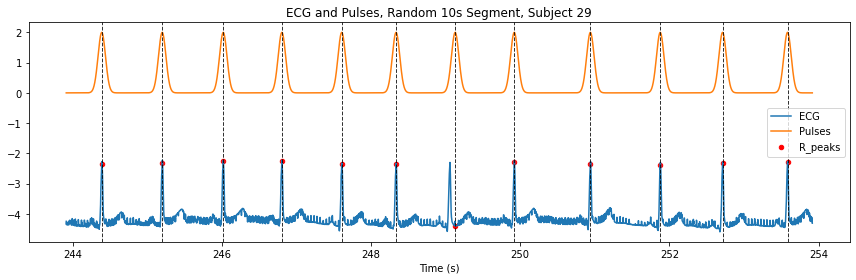

ECG -> Sampling frequency: 500.0 Hz, Signal duration: 428.97 seconds, Channels: 1, no. of points: 214485, no. of R peaks: 452
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 428.97 seconds, Channels: 90, no. of points: 214485


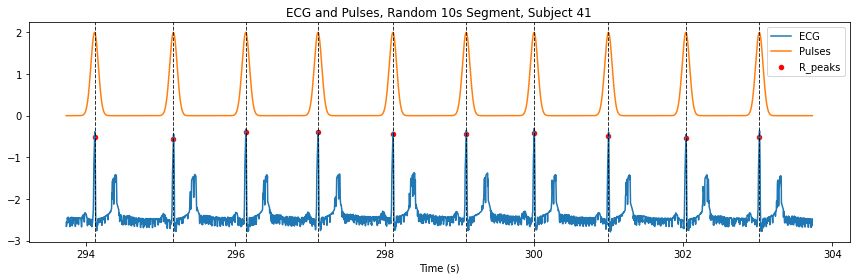

ECG -> Sampling frequency: 500.0 Hz, Signal duration: 466.57 seconds, Channels: 1, no. of points: 233285, no. of R peaks: 770
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 466.57 seconds, Channels: 90, no. of points: 233285


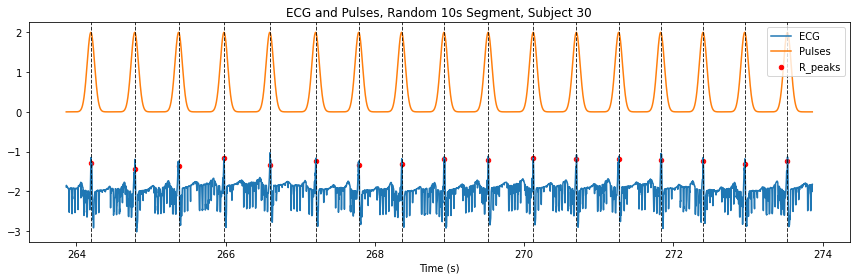

ECG -> Sampling frequency: 500.0 Hz, Signal duration: 462.22 seconds, Channels: 1, no. of points: 231110, no. of R peaks: 711
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 462.22 seconds, Channels: 90, no. of points: 231110


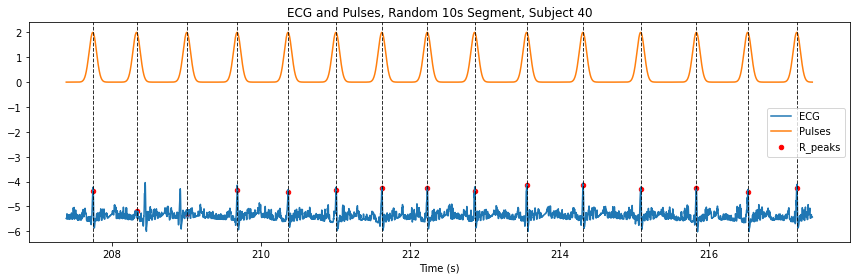

ECG -> Sampling frequency: 500.0 Hz, Signal duration: 509.77 seconds, Channels: 1, no. of points: 254885, no. of R peaks: 537
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 509.77 seconds, Channels: 90, no. of points: 254885


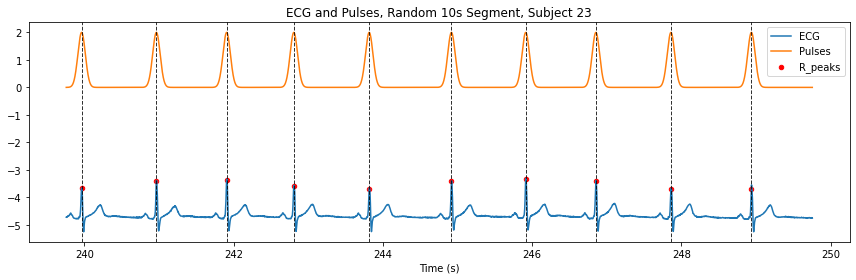

ECG -> Sampling frequency: 500.0 Hz, Signal duration: 446.216 seconds, Channels: 1, no. of points: 223108, no. of R peaks: 549
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 446.216 seconds, Channels: 90, no. of points: 223108


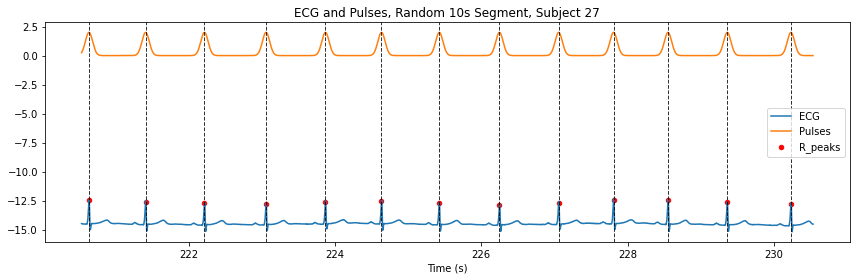

ECG -> Sampling frequency: 500.0 Hz, Signal duration: 422.668 seconds, Channels: 1, no. of points: 211334, no. of R peaks: 505
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 422.668 seconds, Channels: 90, no. of points: 211334


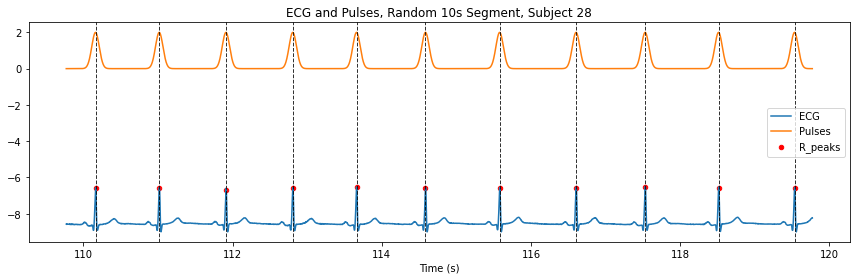

ECG -> Sampling frequency: 500.0 Hz, Signal duration: 400.918 seconds, Channels: 1, no. of points: 200459, no. of R peaks: 489
EEG -> Sampling frequency: 500.0 Hz, Signal duration: 400.918 seconds, Channels: 90, no. of points: 200459


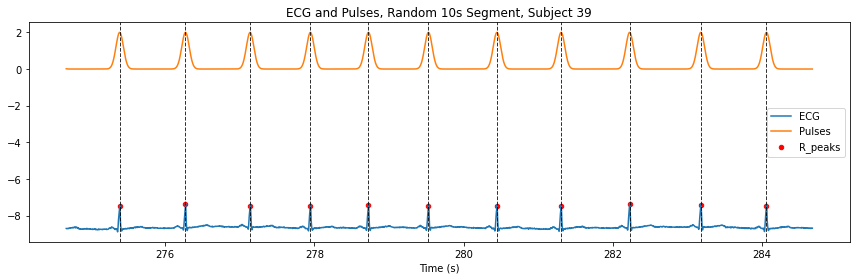

In [5]:
data_parsed = {}  # main dictionary: keys are subjects

if load_from_file and os.path.exists(parsed_path):
    with open(parsed_path, "rb") as f:
        data_parsed = pickle.load(f)
    print(f"Loaded data_parsed from {parsed_path}")
    # visualize each subject from cached data
    for ss in subj_all:
        d = data_parsed[ss]
        visualize_ecg_and_peaks(ss, d['ECG'], d['ECG_pulse'], d['EEG'], d['R_peaks'], d['time'], d['freq'], duration_sec=duration_sec)
else:
    for ss in subj_all:
        print(f"\nLoading training data for subject {ss}...")

        # Load preprocessed EEG
        data = loadmat(f'Signals/P0{ss:02d}_prepro.mat')
        EEG_prepro = data['EEG_prepro']
        Y_prepro = EEG_prepro['data'][0, 0].astype(float)
        freq_prepro = float(EEG_prepro['srate'][0, 0])

        # Load ECG
        ecg_data = loadmat(f'Signals/P0{ss:02d}.mat')
        t_prepro = ecg_data["t_int"].flatten()
        t_prepro = np.insert(t_prepro, 0, 0.0)  # add a first point 0.0 to correct the shape

        R_peak = ecg_data['R_peak'].flatten() - 1
        ECG = ecg_data['ECG_i'].flatten() 
        ECG = np.insert(ECG, len(ECG), ECG[len(ECG) - 1])  # add a last point to correct the shape, by repeating the last point

        # Pulse train
        ECG_pulse = train_pulse(Y_prepro, R_peak, A, width, freq_prepro, impulso)

        # Store in nested dictionary
        data_parsed[ss] = {
            'ECG': ECG,
            'ECG_pulse': ECG_pulse,
            'R_peaks': R_peak,
            'EEG': Y_prepro,
            'time': t_prepro,
            'freq': freq_prepro
        }

        visualize_ecg_and_peaks(ss, ECG, ECG_pulse, Y_prepro, R_peak, t_prepro, freq_prepro, duration_sec=duration_sec)

    os.makedirs(cache_dir, exist_ok=True)
    with open(parsed_path, "wb") as f:
        pickle.dump(data_parsed, f)
    print(f"Saved data_parsed to {parsed_path}")

Loaded data_preprocessed from cache/data_preprocessed.pkl
ECG -> Sampling frequency: 100 Hz, Signal duration: 466.57 seconds, Channels: 1, no. of points: 46657, no. of R peaks: 546
EEG -> Sampling frequency: 100 Hz, Signal duration: 466.57 seconds, Channels: 90, no. of points: 46657


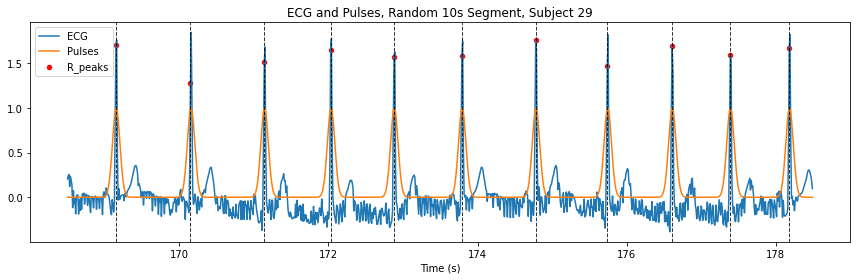

ECG -> Sampling frequency: 100 Hz, Signal duration: 428.97 seconds, Channels: 1, no. of points: 42897, no. of R peaks: 452
EEG -> Sampling frequency: 100 Hz, Signal duration: 428.97 seconds, Channels: 90, no. of points: 42897


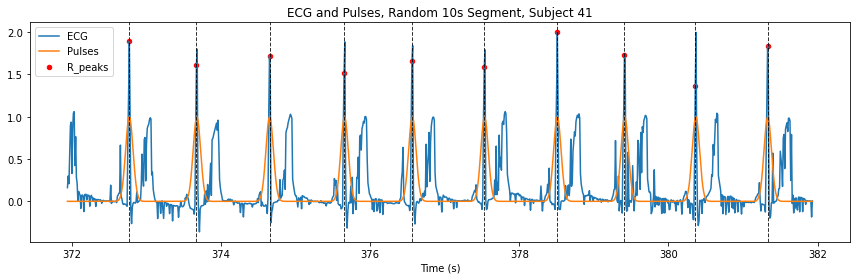

ECG -> Sampling frequency: 100 Hz, Signal duration: 466.57 seconds, Channels: 1, no. of points: 46657, no. of R peaks: 770
EEG -> Sampling frequency: 100 Hz, Signal duration: 466.57 seconds, Channels: 90, no. of points: 46657


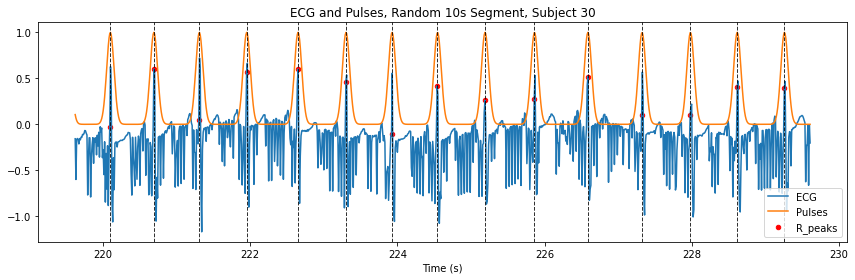

ECG -> Sampling frequency: 100 Hz, Signal duration: 462.22 seconds, Channels: 1, no. of points: 46222, no. of R peaks: 711
EEG -> Sampling frequency: 100 Hz, Signal duration: 462.22 seconds, Channels: 90, no. of points: 46222


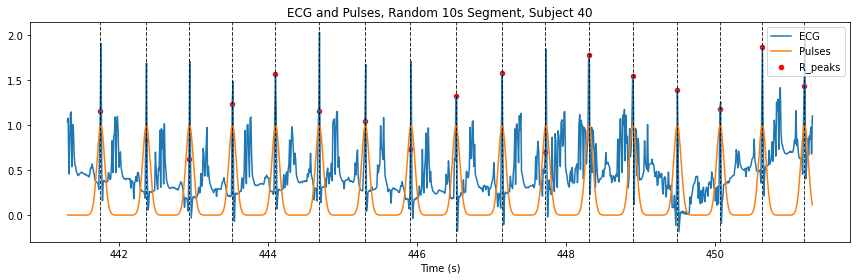

ECG -> Sampling frequency: 100 Hz, Signal duration: 509.77 seconds, Channels: 1, no. of points: 50977, no. of R peaks: 537
EEG -> Sampling frequency: 100 Hz, Signal duration: 509.77 seconds, Channels: 90, no. of points: 50977


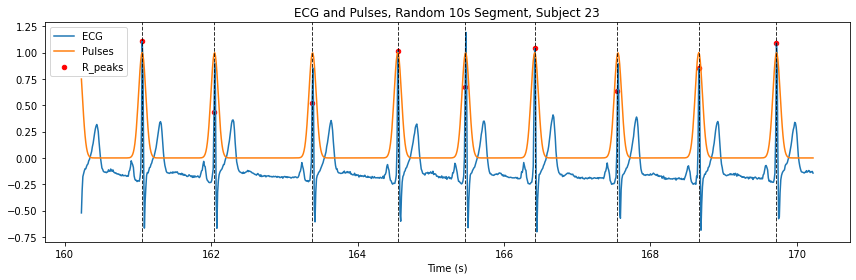

ECG -> Sampling frequency: 100 Hz, Signal duration: 446.22 seconds, Channels: 1, no. of points: 44622, no. of R peaks: 549
EEG -> Sampling frequency: 100 Hz, Signal duration: 446.22 seconds, Channels: 90, no. of points: 44622


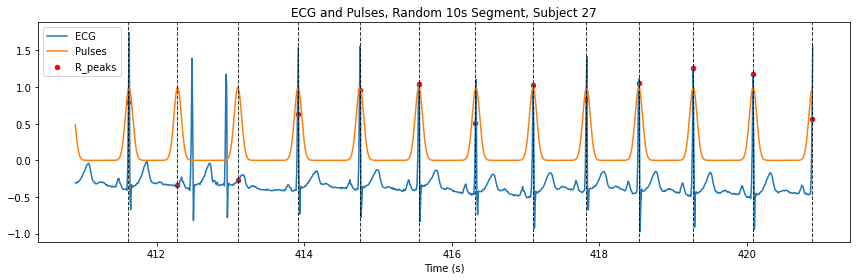

ECG -> Sampling frequency: 100 Hz, Signal duration: 422.67 seconds, Channels: 1, no. of points: 42267, no. of R peaks: 505
EEG -> Sampling frequency: 100 Hz, Signal duration: 422.67 seconds, Channels: 90, no. of points: 42267


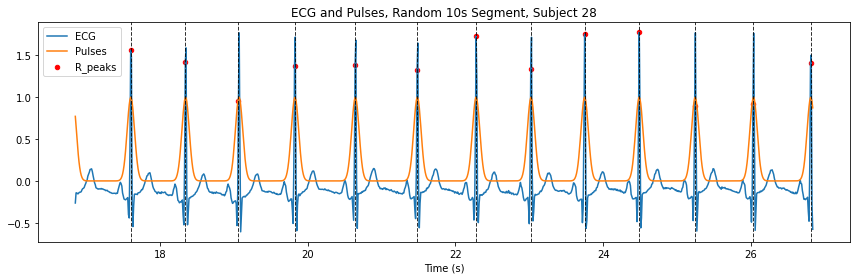

ECG -> Sampling frequency: 100 Hz, Signal duration: 400.92 seconds, Channels: 1, no. of points: 40092, no. of R peaks: 489
EEG -> Sampling frequency: 100 Hz, Signal duration: 400.92 seconds, Channels: 90, no. of points: 40092


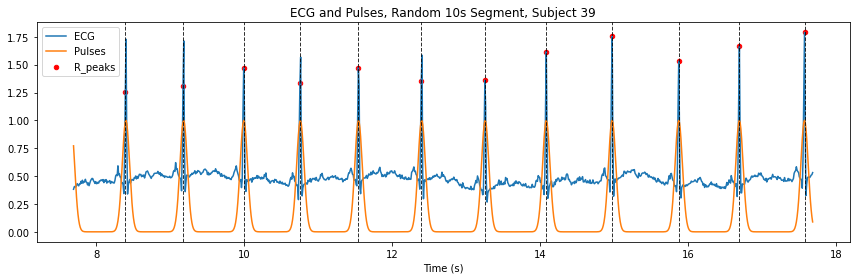

In [6]:
data_preprocessed = {}

if load_from_file and os.path.exists(preproc_path):
    with open(preproc_path, "rb") as f:
        data_preprocessed = pickle.load(f)
    print(f"Loaded data_preprocessed from {preproc_path}")
    for ss in subj_all:
        d = data_preprocessed[ss]
        visualize_ecg_and_peaks(ss, d['ECG'], d['ECG_pulse'], d['EEG'], d['R_peaks'], d['time'], d['freq'], duration_sec=duration_sec)
else:
    for ss in subj_all:

        ECG = data_parsed[ss]['ECG'].copy() - np.mean(data_parsed[ss]['ECG'])
        ECG = ECG[::tau]

        ECG_pulse = minmax_scale(data_parsed[ss]['ECG_pulse'].copy().reshape(1, -1), feature_range=(0, 1), axis=1).flatten()
        ECG_pulse = ECG_pulse[::tau]

        EEG = minmax_scale(data_parsed[ss]['EEG'].copy(), feature_range=(0, 1), axis=1)
        EEG = EEG - np.mean(EEG, axis=1, keepdims=True)
        EEG = EEG[:, ::tau]

        R_peaks = data_parsed[ss]['R_peaks'].copy() // tau

        time = data_parsed[ss]['time'].copy()[::tau]
        freq = int(data_parsed[ss]['freq'] / tau)

        data_preprocessed[ss] = {
            'ECG': ECG,
            'ECG_pulse': ECG_pulse,
            'R_peaks': R_peaks,
            'EEG': EEG,
            'time': time,
            'freq': freq
        }

        visualize_ecg_and_peaks(ss, ECG, ECG_pulse, EEG, R_peaks, time, freq, duration_sec=duration_sec)

    os.makedirs(cache_dir, exist_ok=True)
    with open(preproc_path, "wb") as f:
        pickle.dump(data_preprocessed, f)
    print(f"Saved data_preprocessed to {preproc_path}")

## 10-second segmentation and subject split

- Use one subject as test, train on all others.
- Segments are contiguous 10-second windows (non-overlapping).

In [7]:
# Choose held-out subjects: test and validation (must be in subj_all)
test_subj = subj_all[0]
val_subj = subj_all[1]
assert test_subj in subj_all and val_subj in subj_all, "Subjects must be one of subj_all"
assert val_subj != test_subj, "val_subj must differ from test_subj"

freq_common = data_preprocessed[subj_all[0]]['freq']
seg_len = int(duration_sec * freq_common)

# Augmentation: use larger segments for training
aug_seg_len = int(aug_segment_duration * freq_common) if use_augmentation else seg_len

# Overlap for training windows (0.0 = no overlap, 0.5 = 50% overlap for TRAIN only)
train_overlap = 0.9
train_stride = max(1, int(seg_len * (1.0 - train_overlap)))

n_channels = data_preprocessed[subj_all[0]]['EEG'].shape[0]
print(f"Test subject: {test_subj} | Val subject: {val_subj} | freq={freq_common} Hz | seg_len={seg_len} samples | stride(train)={train_stride} | overlap(train)={train_overlap:.2f} | channels={n_channels}")
if use_augmentation:
    print(f"Augmentation enabled: aug_seg_len={aug_seg_len} samples ({aug_segment_duration}s), warp_factor_range={warp_factor_range}")

Test subject: 29 | Val subject: 41 | freq=100 Hz | seg_len=1000 samples | stride(train)=99 | overlap(train)=0.90 | channels=90
Augmentation enabled: aug_seg_len=1400 samples (14s), warp_factor_range=(0.85, 1.15)


In [8]:
def build_segments(EEG, pulse, seg_len, stride=None):
    """
    EEG: (C, T), pulse: (T,)
    returns X: (N, seg_len, C), y: (N, seg_len, 1)
    If stride is None or stride >= seg_len, uses non-overlapping windows.
    Otherwise uses sliding windows with given stride (overlap = 1 - stride/seg_len).
    """
    C, T = EEG.shape
    if T < seg_len:
        return np.empty((0, seg_len, C)), np.empty((0, seg_len, 1))

    if stride is None or stride >= seg_len:
        n_seg = T // seg_len
        if n_seg == 0:
            return np.empty((0, seg_len, C)), np.empty((0, seg_len, 1))
        EEG_tc = EEG[:, :n_seg * seg_len].T  # (T, C)
        X = EEG_tc.reshape(n_seg, seg_len, C)
        y = pulse[:n_seg * seg_len].reshape(n_seg, seg_len, 1)
        return X, y

    # Sliding windows (overlapping)
    starts = np.arange(0, T - seg_len + 1, stride, dtype=int)
    if starts.size == 0:
        return np.empty((0, seg_len, C)), np.empty((0, seg_len, 1))
    X_list = [EEG[:, s:s + seg_len].T for s in starts]
    y_list = [pulse[s:s + seg_len][..., None] for s in starts]
    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y

# New: segment a 1D signal (e.g., ECG) with same stride logic
def build_segments_1d(sig, seg_len, stride=None):
    T = len(sig)
    if T < seg_len:
        return np.empty((0, seg_len))
    if stride is None or stride >= seg_len:
        n_seg = T // seg_len
        if n_seg == 0:
            return np.empty((0, seg_len))
        return sig[:n_seg * seg_len].reshape(n_seg, seg_len)
    starts = np.arange(0, T - seg_len + 1, stride, dtype=int)
    if starts.size == 0:
        return np.empty((0, seg_len))
    return np.stack([sig[s:s + seg_len] for s in starts], axis=0)

# Assemble train/val/test datasets
X_train_list, y_train_list = [], []
train_ids_list = []
ecg_train_list = []
for s in subj_all:
    if s in (test_subj, val_subj):
        continue
    
    if use_augmentation:
        # Build larger segments for augmentation
        Xs_large, ys_large = build_segments(
            data_preprocessed[s]['EEG'],
            data_preprocessed[s]['ECG_pulse'],
            aug_seg_len,
            stride=train_stride
        )
        Ecgs_large = build_segments_1d(
            data_preprocessed[s]['ECG'],
            aug_seg_len,
            stride=train_stride
        )
        
        if Xs_large.size == 0:
            continue
        
        # First: extract center window from larger segments (original, non-warped)
        Xs_orig, ys_orig, Ecgs_orig = [], [], []
        for i in range(len(Xs_large)):
            eeg_seg = Xs_large[i]  # (aug_seg_len, C)
            pulse_seg = ys_large[i].squeeze()  # (aug_seg_len,)
            ecg_seg = Ecgs_large[i]  # (aug_seg_len,)
            
            # Extract center window of seg_len
            start_idx = (aug_seg_len - seg_len) // 2
            eeg_center = eeg_seg[start_idx:start_idx + seg_len]
            pulse_center = pulse_seg[start_idx:start_idx + seg_len]
            ecg_center = ecg_seg[start_idx:start_idx + seg_len]
            
            Xs_orig.append(eeg_center)
            ys_orig.append(pulse_center)
            Ecgs_orig.append(ecg_center)
        
        # Second: create augmented versions with time warping
        Xs_aug, ys_aug, Ecgs_aug = [], [], []
        for i in range(len(Xs_large)):
            eeg_seg = Xs_large[i]  # (aug_seg_len, C)
            pulse_seg = ys_large[i].squeeze()  # (aug_seg_len,)
            ecg_seg = Ecgs_large[i]  # (aug_seg_len,)
            
            # Transpose for warping: (C, T)
            eeg_seg_t = eeg_seg.T
            
            # Create n_augmented_per_segment warped versions
            for _ in range(n_augmented_per_segment):
                # Apply same random warp to EEG, pulse, and ECG
                rng_state = np.random.get_state()
                eeg_warped = apply_time_warp(eeg_seg_t, axis=-1)  # (C, T_warped)
                np.random.set_state(rng_state)
                pulse_warped = apply_time_warp(pulse_seg, axis=-1)  # (T_warped,)
                np.random.set_state(rng_state)
                ecg_warped = apply_time_warp(ecg_seg, axis=-1)  # (T_warped,)
                
                # Extract random window of target length
                if eeg_warped.shape[-1] >= seg_len:
                    rng_state = np.random.get_state()
                    eeg_window = extract_random_window(eeg_warped, seg_len, axis=-1)
                    np.random.set_state(rng_state)
                    pulse_window = extract_random_window(pulse_warped, seg_len, axis=-1)
                    np.random.set_state(rng_state)
                    ecg_window = extract_random_window(ecg_warped, seg_len, axis=-1)
                    
                    # Transpose back: (T, C)
                    Xs_aug.append(eeg_window.T)
                    ys_aug.append(pulse_window)
                    Ecgs_aug.append(ecg_window)
        
        # Combine original and augmented
        all_Xs = Xs_orig + Xs_aug
        all_ys = ys_orig + ys_aug
        all_Ecgs = Ecgs_orig + Ecgs_aug
        
        if len(all_Xs) > 0:
            Xs = np.stack(all_Xs, axis=0)
            ys = np.stack(all_ys, axis=0)[..., None]
            Ecgs = np.stack(all_Ecgs, axis=0)
            print(f"Subject {s}: {len(Xs_orig)} original + {len(Xs_aug)} augmented = {len(all_Xs)} total segments")
        else:
            continue
    else:
        # No augmentation: use normal segment building
        Xs, ys = build_segments(
            data_preprocessed[s]['EEG'],
            data_preprocessed[s]['ECG_pulse'],
            seg_len,
            stride=train_stride
        )
        Ecgs = build_segments_1d(
            data_preprocessed[s]['ECG'],
            seg_len,
            stride=train_stride
        )
    
    if Xs.size:
        X_train_list.append(Xs)
        y_train_list.append(ys)
        ecg_train_list.append(Ecgs)
        train_ids_list.append(np.full((Xs.shape[0],), s, dtype=np.int32))

# Validation: dedicated subject (non-overlapping, NO augmentation)
X_val, y_val = build_segments(
    data_preprocessed[val_subj]['EEG'],
    data_preprocessed[val_subj]['ECG_pulse'],
    seg_len,
    stride=None
)
# New: ECG segments for val
ECG_val = build_segments_1d(
    data_preprocessed[val_subj]['ECG'],
    seg_len,
    stride=None
)

# Test: held-out subject (non-overlapping, NO augmentation)
X_test, y_test = build_segments(
    data_preprocessed[test_subj]['EEG'],
    data_preprocessed[test_subj]['ECG_pulse'],
    seg_len,
    stride=None
)
# New: ECG segments for test
ECG_test = build_segments_1d(
    data_preprocessed[test_subj]['ECG'],
    seg_len,
    stride=None
)

X_train = np.concatenate(X_train_list, axis=0) if X_train_list else np.empty((0, seg_len, n_channels))
y_train = np.concatenate(y_train_list, axis=0) if y_train_list else np.empty((0, seg_len, 1))
train_seg_subjects = np.concatenate(train_ids_list, axis=0) if train_ids_list else np.empty((0,), dtype=np.int32)
# New: concatenate ECG train segments
ECG_train = np.concatenate(ecg_train_list, axis=0) if ecg_train_list else np.empty((0, seg_len))

y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

print(f"Train segments: {X_train.shape}, Val segments: {X_val.shape}, Test segments: {X_test.shape}")
print(f"Train ECG_pulse: {y_train.shape}, Val ECG_pulse: {y_val.shape}, Test ECG_pulse: {y_test.shape}")

Subject 30: 458 original + 2290 augmented = 2748 total segments
Subject 40: 453 original + 2265 augmented = 2718 total segments
Subject 40: 453 original + 2265 augmented = 2718 total segments
Subject 23: 501 original + 2505 augmented = 3006 total segments
Subject 23: 501 original + 2505 augmented = 3006 total segments
Subject 27: 437 original + 2185 augmented = 2622 total segments
Subject 27: 437 original + 2185 augmented = 2622 total segments
Subject 28: 413 original + 2065 augmented = 2478 total segments
Subject 28: 413 original + 2065 augmented = 2478 total segments
Subject 39: 391 original + 1955 augmented = 2346 total segments
Subject 39: 391 original + 1955 augmented = 2346 total segments
Train segments: (15918, 1000, 90), Val segments: (42, 1000, 90), Test segments: (46, 1000, 90)
Train ECG_pulse: (15918, 1000), Val ECG_pulse: (42, 1000), Test ECG_pulse: (46, 1000)
Train segments: (15918, 1000, 90), Val segments: (42, 1000, 90), Test segments: (46, 1000, 90)
Train ECG_pulse: (15

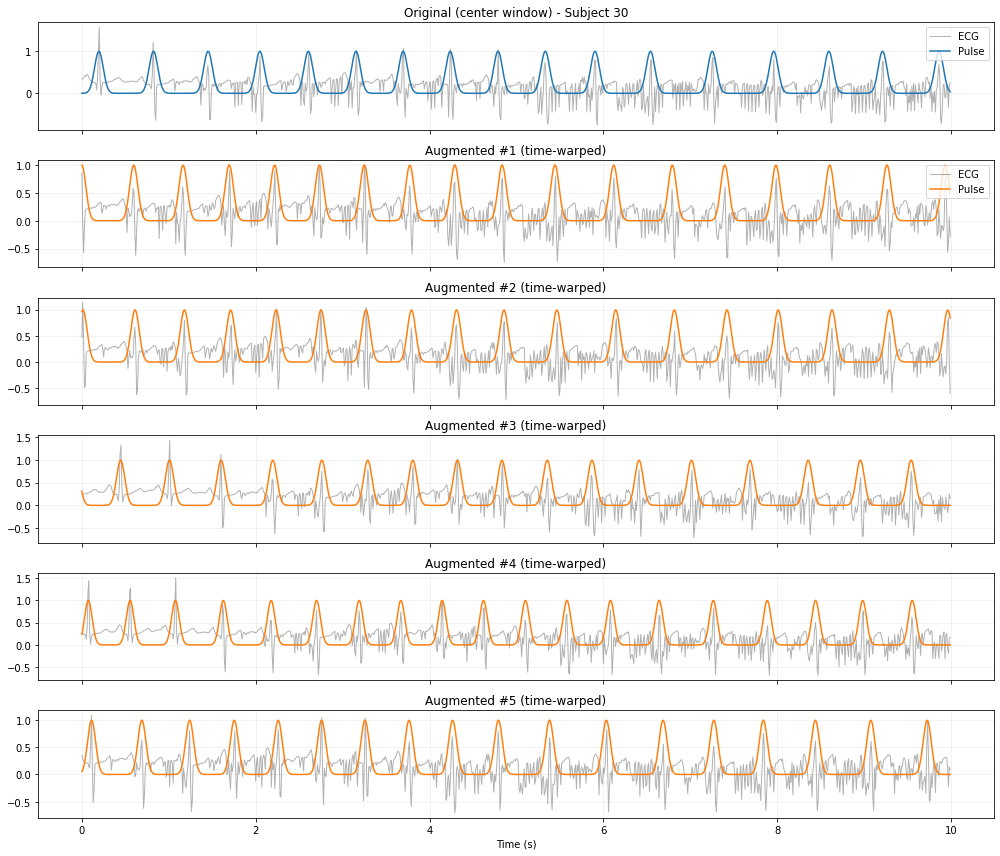


Showing 1 original + 5 augmented versions from subject 30
Augmentation creates 5 additional samples per original segment


In [24]:
# Visualize augmentation: show one original segment and its 5 warped versions
if use_augmentation and len(subj_all) > 2:
    # Pick a random training subject
    train_subjects = [s for s in subj_all if s not in (test_subj, val_subj)]
    demo_subj = train_subjects[0]
    
    # Build one larger segment for demonstration
    Xs_demo, ys_demo = build_segments(
        data_preprocessed[demo_subj]['EEG'],
        data_preprocessed[demo_subj]['ECG_pulse'],
        aug_seg_len,
        stride=None
    )
    Ecgs_demo = build_segments_1d(
        data_preprocessed[demo_subj]['ECG'],
        aug_seg_len,
        stride=None
    )
    
    if len(Xs_demo) > 0:
        # Take the first segment
        eeg_seg = Xs_demo[0]  # (aug_seg_len, C)
        pulse_seg = ys_demo[0].squeeze()  # (aug_seg_len,)
        ecg_seg = Ecgs_demo[0]  # (aug_seg_len,)
        
        # Extract center window (original)
        start_idx = (aug_seg_len - seg_len) // 2
        eeg_orig = eeg_seg[start_idx:start_idx + seg_len]
        pulse_orig = pulse_seg[start_idx:start_idx + seg_len]
        ecg_orig = ecg_seg[start_idx:start_idx + seg_len]
        
        # Create 5 augmented versions
        eeg_seg_t = eeg_seg.T
        augs = []
        for i in range(5):
            rng_state = np.random.get_state()
            eeg_warped = apply_time_warp(eeg_seg_t, axis=-1)
            np.random.set_state(rng_state)
            pulse_warped = apply_time_warp(pulse_seg, axis=-1)
            np.random.set_state(rng_state)
            ecg_warped = apply_time_warp(ecg_seg, axis=-1)
            
            if eeg_warped.shape[-1] >= seg_len:
                rng_state = np.random.get_state()
                eeg_window = extract_random_window(eeg_warped, seg_len, axis=-1)
                np.random.set_state(rng_state)
                pulse_window = extract_random_window(pulse_warped, seg_len, axis=-1)
                np.random.set_state(rng_state)
                ecg_window = extract_random_window(ecg_warped, seg_len, axis=-1)
                
                augs.append({
                    'eeg': eeg_window.T,
                    'pulse': pulse_window,
                    'ecg': ecg_window
                })
        
        # Plot: 1 original + 5 augmented = 6 subplots
        t = np.arange(seg_len) / float(freq_common)
        fig, axes = plt.subplots(6, 1, figsize=(14, 12), sharex=True)
        
        # Plot original
        axes[0].plot(t, ecg_orig, label='ECG', color='k', alpha=0.3, linewidth=1)
        axes[0].plot(t, pulse_orig, label='Pulse', linewidth=1.5, color='C0')
        axes[0].set_title(f'Original (center window) - Subject {demo_subj}')
        axes[0].grid(True, alpha=0.2)
        axes[0].legend(loc='upper right')
        
        # Plot augmented versions
        for i, aug in enumerate(augs):
            axes[i+1].plot(t, aug['ecg'], label='ECG', color='k', alpha=0.3, linewidth=1)
            axes[i+1].plot(t, aug['pulse'], label='Pulse', linewidth=1.5, color='C1')
            axes[i+1].set_title(f'Augmented #{i+1} (time-warped)')
            axes[i+1].grid(True, alpha=0.2)
            if i == 0:
                axes[i+1].legend(loc='upper right')
        
        axes[-1].set_xlabel('Time (s)')
        plt.tight_layout()
        plt.show()
        
        print(f"\nShowing 1 original + {len(augs)} augmented versions from subject {demo_subj}")
        print(f"Augmentation creates {len(augs)} additional samples per original segment")

In [ ]:
X_tr, y_tr = X_train, y_train  # train on all non-test, non-val subjects

X_tr_t = torch.from_numpy(X_tr.astype(np.float32))
y_tr_t = torch.from_numpy(y_tr.astype(np.float32))
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

train_ds = TensorDataset(X_tr_t, y_tr_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)  # use true labels for metrics

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [10]:


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0, use_spatial_dropout=True):
        super().__init__()
        layers = [
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        ]
        self.net = nn.Sequential(*layers)
        self.dropout = dropout
        self.use_spatial = use_spatial_dropout and dropout > 0.0
        if self.use_spatial:
            # Dropout2d will drop entire channels for (N, C, L) inputs
            self.sd = nn.Dropout2d(dropout)
        elif dropout > 0.0:
            self.d = nn.Dropout(dropout)

    def forward(self, x):
        x = self.net(x)
        if self.dropout > 0.0:
            if self.use_spatial:
                x = self.sd(x)
            else:
                x = self.d(x)
        return x

class UNet1D(nn.Module):
    def __init__(self, in_ch, base_ch=32, out_ch=1, dropout=0.2, use_spatial_dropout=True):
        """
        in_ch: number of input channels (e.g. EEG channels)
        input shape expected: (B, T, C) as in your original code
        base_ch: reduced from 64->32 by default to lower capacity
        dropout: float (0.0 -> no dropout)
        use_spatial_dropout: use Dropout2d (channel dropout) if True
        """
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(in_ch, base_ch, dropout=dropout, use_spatial_dropout=use_spatial_dropout)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2, dropout=dropout, use_spatial_dropout=use_spatial_dropout)
        self.pool2 = nn.MaxPool1d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4, dropout=dropout, use_spatial_dropout=use_spatial_dropout)
        self.pool3 = nn.MaxPool1d(2)

        # Bottleneck (smaller and with dropout)
        self.bottleneck = ConvBlock(base_ch * 4, base_ch * 8, dropout=dropout, use_spatial_dropout=False)
        self.bottleneck_drop = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()

        # Decoder
        self.up3 = nn.ConvTranspose1d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4, dropout=dropout, use_spatial_dropout=use_spatial_dropout)
        self.up2 = nn.ConvTranspose1d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2, dropout=dropout, use_spatial_dropout=use_spatial_dropout)
        self.up1 = nn.ConvTranspose1d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch, dropout=dropout, use_spatial_dropout=use_spatial_dropout)

        self.out_conv = nn.Conv1d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):  # x: (B, T, C)
        x = x.transpose(1, 2)  # (B, C, T)
        e1 = self.enc1(x)      # (B, base, T)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        b = self.bottleneck(p3)
        b = self.bottleneck_drop(b)

        d3 = self.up3(b)
        # If upsampling causes off-by-one length, center-crop/resample e3 to match d3; here assume exact divisibility
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)  # (B, 1, T)
        out = out.transpose(1, 2).squeeze(-1)  # (B, T)
        return out

model = UNet1D(in_ch=n_channels, base_ch=8, out_ch=1, dropout=0.5, use_spatial_dropout=False).to(device)

summary(
    model, 
    input_size=(1, seg_len, n_channels),
    col_names=["input_size", "output_size", "num_params"],
    depth=4,
    verbose=1
)
print("")

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet1D                                   [1, 1000, 90]             [1, 1000]                 --
├─ConvBlock: 1-1                         [1, 90, 1000]             [1, 8, 1000]              --
│    └─Sequential: 2-1                   [1, 90, 1000]             [1, 8, 1000]              --
│    │    └─Conv1d: 3-1                  [1, 90, 1000]             [1, 8, 1000]              2,168
│    │    └─BatchNorm1d: 3-2             [1, 8, 1000]              [1, 8, 1000]              16
│    │    └─ReLU: 3-3                    [1, 8, 1000]              [1, 8, 1000]              --
│    │    └─Conv1d: 3-4                  [1, 8, 1000]              [1, 8, 1000]              200
│    │    └─BatchNorm1d: 3-5             [1, 8, 1000]              [1, 8, 1000]              16
│    │    └─ReLU: 3-6                    [1, 8, 1000]              [1, 8, 1000]              --
│    └─Dropout: 2-2            

Epoch 01 - train loss: 0.15537, train mae: 0.26628, val_loss: 0.15176, val mae: 0.19851, test mae: 0.20551
Epoch 02 - train loss: 0.08933, train mae: 0.21827, val_loss: 0.14294, val mae: 0.19331, test mae: 0.21195
Epoch 02 - train loss: 0.08933, train mae: 0.21827, val_loss: 0.14294, val mae: 0.19331, test mae: 0.21195
Epoch 03 - train loss: 0.07514, train mae: 0.19481, val_loss: 0.14955, val mae: 0.18647, test mae: 0.20157
Epoch 03 - train loss: 0.07514, train mae: 0.19481, val_loss: 0.14955, val mae: 0.18647, test mae: 0.20157
Epoch 04 - train loss: 0.06509, train mae: 0.17593, val_loss: 0.15653, val mae: 0.19351, test mae: 0.20540
Epoch 04 - train loss: 0.06509, train mae: 0.17593, val_loss: 0.15653, val mae: 0.19351, test mae: 0.20540
Epoch 05 - train loss: 0.05961, train mae: 0.16682, val_loss: 0.16235, val mae: 0.18841, test mae: 0.20148
Epoch 05 - train loss: 0.05961, train mae: 0.16682, val_loss: 0.16235, val mae: 0.18841, test mae: 0.20148
Epoch 06 - train loss: 0.05723, train

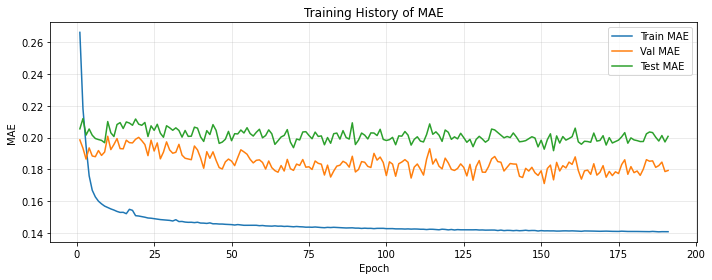

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Track MAE history
train_mae_hist, val_mae_hist, test_mae_hist = [], [], []

# Early stopping
best_val = float('inf')
best_state = None
patience = 40
wait = 0
best_epoch = 0
epochs = 200

def evaluate_subject(loader, criterion):
    model.eval()
    loss, mae, m = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            loss += loss.item()
            mae += (pred - yb).abs().mean().item()
            m += 1
    loss /= max(m, 1)
    mae /= max(m, 1)
    return loss, mae


for epoch in range(1, epochs + 1):
    # Train
    model.train()
    train_loss, train_mae, n_batches = 0.0, 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)  #.squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_mae += (pred.detach() - yb).abs().mean().item()
        n_batches += 1
    train_loss /= max(n_batches, 1)
    train_mae /= max(n_batches, 1)

    # Validate
    val_loss, val_mae = evaluate_subject(val_loader, criterion)
    test_loss, test_mae = evaluate_subject(test_loader, criterion)

    # Log
    train_mae_hist.append(train_mae)
    val_mae_hist.append(val_mae)
    test_mae_hist.append(test_mae)
    print(f"Epoch {epoch:02d} - train loss: {train_loss:.5f}, train mae: {train_mae:.5f}, val_loss: {val_loss:.5f}, val mae: {val_mae:.5f}, test mae: {test_mae:.5f}")

    if epoch > 20 and val_mae < best_val - 1e-6:
        best_val = val_mae
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
        best_epoch = epoch
    elif epoch > 20:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break 

if best_state is not None:
    model.load_state_dict(best_state)
model.to(device)
print("Best Val Epoch:", best_epoch)

# Plot MAE history
epochs_axis = np.arange(1, len(train_mae_hist) + 1)
plt.figure(figsize=(10, 4))
plt.plot(epochs_axis, train_mae_hist, label='Train MAE')
plt.plot(epochs_axis, val_mae_hist, label='Val MAE')
plt.plot(epochs_axis, test_mae_hist, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training History of MAE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

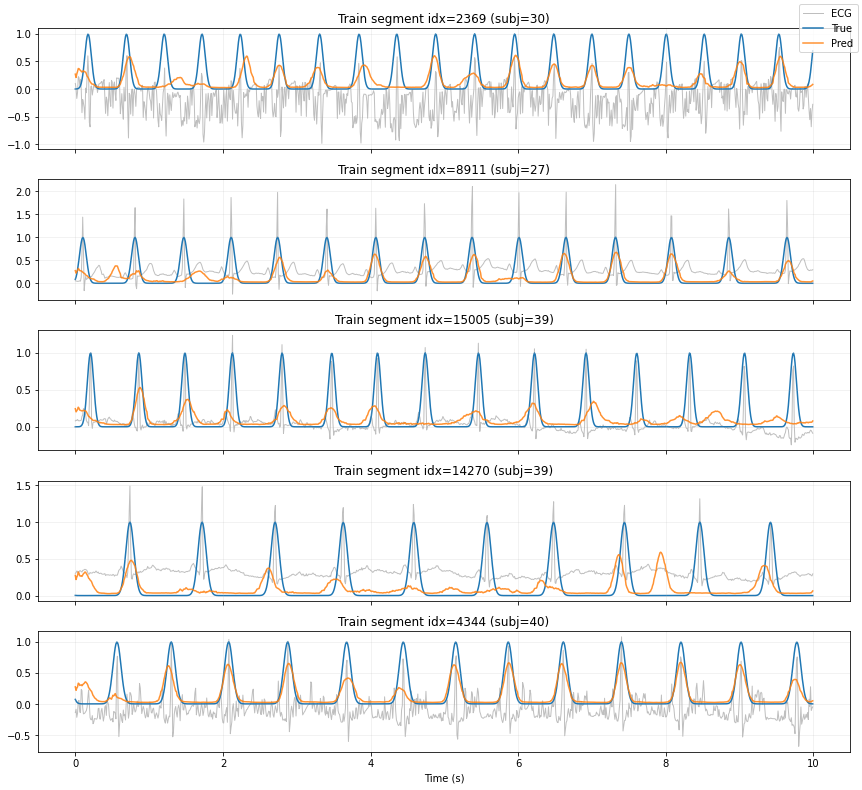

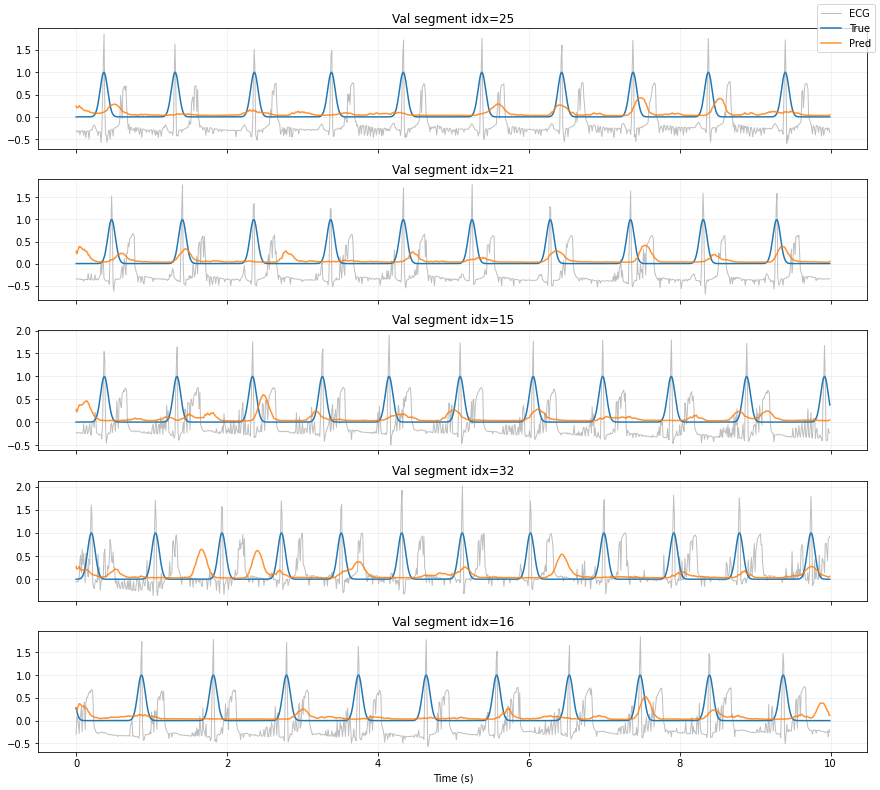

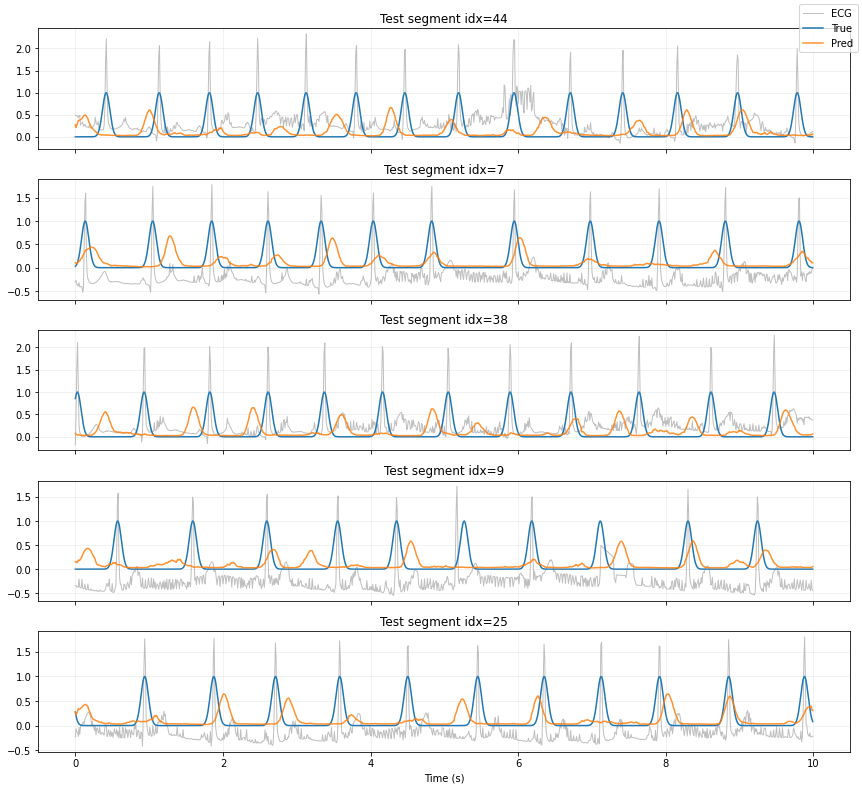

In [17]:
# Visualize 5 segments from Train, Val, and Test with predictions
def _visualize_split(name, X_split, y_split, ecg_split=None, k=5, subj_ids=None):
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    if X_split is None or len(X_split) == 0:
        print(f"{name}: no segments to visualize")
        return

    k = min(k, len(X_split))
    idxs = np.random.choice(len(X_split), size=k, replace=False)
    t = np.arange(seg_len) / float(freq_common)

    fig, axes = plt.subplots(k, 1, figsize=(12, 2.2 * k), sharex=True)
    if k == 1:
        axes = [axes]

    for ax, idx in zip(axes, idxs):
        xb = torch.from_numpy(X_split[idx:idx+1].astype(np.float32)).to(device)
        with torch.inference_mode():
            pred = model(xb).cpu().numpy().squeeze()  # (T,)
        # Plot ECG first (behind)
        if ecg_split is not None and len(ecg_split) > int(idx):
            ax.plot(t, ecg_split[int(idx)], label='ECG', color='k', alpha=0.25, linewidth=1, zorder=0)
        # Then true and predicted pulse
        ax.plot(t, y_split[idx], label='True', linewidth=1.5, zorder=1)
        ax.plot(t, pred, label='Pred', alpha=0.85, zorder=2)
        subj_str = f" (subj={int(subj_ids[idx])})" if subj_ids is not None and len(subj_ids) > int(idx) else ""
        ax.set_title(f"{name} segment idx={int(idx)}{subj_str}")
        ax.grid(True, alpha=0.2)

    axes[-1].set_xlabel('Time (s)')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.tight_layout()
    plt.show()


# Expect X_tr, y_tr, X_val, y_val, X_test, y_test, ECG_train, ECG_val, ECG_test, seg_len, freq_common, model, device to be defined above
_visualize_split('Train', X_tr, y_tr, ecg_split=ECG_train, k=5, subj_ids=train_seg_subjects)
_visualize_split('Val', X_val, y_val, ecg_split=ECG_val, k=5)
_visualize_split('Test', X_test, y_test, ecg_split=ECG_test, k=5)

In [15]:
# Compute and print MAE per each training subject
import numpy as np
import torch

if 'train_seg_subjects' not in globals() or train_seg_subjects is None or len(train_seg_subjects) == 0:
    print('No training segments found.')
else:
    model.eval()
    subjects = np.unique(train_seg_subjects)
    results = []  # (subject, n_segments, mae)
    for s in subjects:
        idx = np.where(train_seg_subjects == s)[0]
        if idx.size == 0:
            continue
        X_s = X_train[idx].astype(np.float32)
        y_s = y_train[idx].astype(np.float32)

        ds = TensorDataset(torch.from_numpy(X_s), torch.from_numpy(y_s))
        dl = DataLoader(ds, batch_size=64, shuffle=False)

        preds, gts = [], []
        with torch.no_grad():
            for xb, yb in dl:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                preds.append(pred.cpu())
                gts.append(yb.cpu())

        if len(preds) > 0:
            pred_all = torch.cat(preds, dim=0)
            gt_all = torch.cat(gts, dim=0)
            mae = torch.mean(torch.abs(pred_all - gt_all)).item()
            results.append((int(s), len(idx), mae))

    if len(results) == 0:
        print('No results to report.')
    else:
        print('Per-subject Train MAE:')
        for s, nseg, mae in sorted(results, key=lambda x: x[0]):
            print(f'Subject {s}: MAE = {mae:.5f} over {nseg} segments')

Per-subject Train MAE:
Subject 23: MAE = 0.11704 over 3006 segments
Subject 27: MAE = 0.10592 over 2622 segments
Subject 28: MAE = 0.12204 over 2478 segments
Subject 30: MAE = 0.15944 over 2748 segments
Subject 39: MAE = 0.16074 over 2346 segments
Subject 40: MAE = 0.11857 over 2718 segments


In [23]:
val_loss, val_mae = evaluate_subject(val_loader, criterion)
test_loss, test_mae = evaluate_subject(test_loader, criterion)

print(f"\nVal MAE = {val_mae:.5}")
print(f"Test MAE = {test_mae:.5}")


Val MAE = 0.17105
Test MAE = 0.19268
